## What is gravitational wave?

Gravitational waves are disturbances in the curvature of spacetime, generated by accelerated masses, that propagate as waves outward from their source at the speed of light. They were first proposed by Oliver Heaviside in 1893 and then later by Henri Poincaré in 1905 and subsequently predicted in 1916 by Albert Einstein on the basis of his general theory of relativity. Gravitational waves transport energy as gravitational radiation, a form of radiant energy similar to electromagnetic radiation. Newton's law of universal gravitation, part of classical mechanics, does not provide for their existence, since that law is predicated on the assumption that physical interactions propagate instantaneously (at infinite speed) – showing one of the ways the methods of Newtonian physics are unable to explain phenomena associated with relativity.

The first direct observation of gravitational waves was not made until 2015, when a signal generated by the merger of two black holes was received by the LIGO gravitational wave detectors in Livingston, Louisiana, and in Hanford, Washington. The 2017 Nobel Prize in Physics was subsequently awarded to Rainer Weiss, Kip Thorne and Barry Barish for their role in the direct detection of gravitational waves. 

<img src = https://ysjournal.com/wp-content/uploads/2021/02/c-users-hp-desktop-wfh-hml-gettyimages-1088377636.jpeg width=600/>

## Challenge Context

When scientists detected the first class of gravitational waves in 2015, they expected the discoveries to continue. There are four classes, yet at present only signals from merging black holes and neutron stars have been detected. Among those remaining are continuous gravitational-wave signals. These are weak yet long-lasting signals emitted by rapidly-spinning neutron stars. Imagine the mass of our Sun but condensed into a ball the size of a city and spinning over 1,000 times a second. The extreme compactness of these stars, composed of the densest material in the universe, could allow continuous waves to be emitted and then detected on Earth. There are potentially many continuous signals from neutron stars in our own galaxy and the current challenge for scientists is to make the first detection, and hopefully data science can help with this mission.

<img src=https://storage.googleapis.com/kaggle-media/competitions/G2Net-gravitational-waves/O3h0senscurve%20jpeg.jpg width=500/>

This image, taken from a 2021 paper by the LIGO-Virgo-KAGRA collaboration, shows the maximum amplitude of a continuous wave any of these neutron stars could emit without being found by the search analyses. Circled stars show results constraining the physical properties of specific neutron stars. Traditional approaches to detecting these weak and hard-to-find continuous signals are based on matched-filtering variants. Scientists create a bank of possible signal waveform templates and ask how correlated each waveform is with the measured noisy data. High correlation is consistent with the presence of a signal similar to that waveform. Due to the long duration of these signals, banks could easily contain hundreds of quintillions of templates; yet, with so many possible waveforms, scientists don’t have the computational power to use the approach without making approximations that weaken the sensitivity to the signals.

G2Net is a network of Gravitational Wave, Geophysics and Machine Learning. Via an Action from COST (European Cooperation in Science and Technology), a funding agency for research and innovation networks, G2Net aims to create a broad network of scientists. From four different areas of expertise, namely GW physics, Geophysics, Computing Science and Robotics, these scientists have agreed on a common goal of tackling challenges in data analysis and noise characterization for GW detectors.

## Importing librairies and dependancies

As we work with gravitational, wave some libraries are mandatory as Riroriro.

**Riroriro** is a set of Python modules containing functions to simulate the gravitational waveforms of mergers of black holes and/or neutron stars, and calculate several properties of these mergers and waveforms, specifically relating to their observability by gravitational wave detectors. Riroriro combines areas covered by previous gravitational wave models (such as gravitational wave simulation, SNR calculation, horizon distance calculation) into a single package with broader scope and versatility in Python, a programming language that is ubiquitous in astronomy.

In [ ]:
!pip install riroriro
!pip install visualkeras
!pip install git+https://github.com/PyFstat/PyFstat@python37

In [ ]:
import os
import h5py
import gc
import glob
import math
import random
import warnings
import pyfstat
import librosa
import librosa.display
import numpy as np
import pandas as pd
import seaborn as sns
import visualkeras
import riroriro.inspiralfuns as ins
import riroriro.mergerfirstfuns as me1
import riroriro.matchingfuns as mat
import riroriro.mergersecondfuns as me2
import tensorflow as tf
from scipy.signal import istft
from tensorflow.keras import regularizers
from tensorflow.keras import layers
import tensorflow_addons as tfa

from pathlib import Path
from scipy import stats
from tqdm.notebook import tqdm
from scipy import signal
import matplotlib.pyplot as plt
from IPython.display import HTML, display
from tensorflow.keras.utils import plot_model
from sklearn.model_selection   import train_test_split

sns.set_theme()
%matplotlib inline 
warnings.filterwarnings('ignore')
display(HTML('<style>.font-family:verdana; word-spacing:1.5px;</style>'))

## Loading Data

### Exploration of HDF files.

Hierarchical Data Format (HDF) is a set of file formats (HDF4, HDF5) designed to store and organize large amounts of data. Originally developed at the U.S. National Center for Supercomputing Applications, it is supported by The HDF Group, a non-profit corporation whose mission is to ensure continued development of HDF5 technologies and the continued accessibility of data stored in HDF.
In keeping with this goal, the HDF libraries and associated tools are available under a liberal, BSD-like license for general use. HDF is supported by many commercial and non-commercial software platforms and programming languages. The freely available HDF distribution consists of the library, command-line utilities, test suite source, Java interface, and the Java-based HDF Viewer (HDFView).
The current version, HDF5, differs significantly in design and API from the major legacy version HDF4. 

### Architecture of HDF5.

<img src=https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/dev-aten/graphics/HDF5-general/hdf5_structure4.jpg width=600/>

The HDF5 format is designed to address some of the limitations of the HDF4 library, and to address current and anticipated requirements of modern systems and applications. In 2002 it won an R&D 100 Award.
HDF5 simplifies the file structure to include only two major types of object:
HDF Structure Example

* Datasets, which are typed multidimensional arrays
* Groups, which are container structures that can hold datasets and other groups

In [ ]:
# Loading train and test sets.
DATA_PATH = Path('../input/g2net-detecting-continuous-gravitational-waves')
TRAIN_PATH = DATA_PATH/'train'
TEST_PATH = DATA_PATH/'test'

In [ ]:
labels_df = pd.read_csv(DATA_PATH/'train_labels.csv')
labels_df.head()

## Dataset structures

In [ ]:
# Exploration of dataset structures.
def allkeys(obj):
    
    """Recursively find all keys in an h5py.Group."""
    keys = (obj.name,)
    if isinstance(obj, h5py.Group):
        for key, value in obj.items():
            if isinstance(value, h5py.Group):
                keys = keys + allkeys(value)
            else:
                keys = keys + (value.name,)
    return keys

In [ ]:
# printing of two exemples with and without signal.
print(labels_df[labels_df['id']=='cc561e4fc'])
print(labels_df[labels_df['id']=='fb6db0d08'])

In [ ]:
train_example_with_signal_path = TRAIN_PATH/'cc561e4fc.hdf5'# target = 1
train_example_without_signal_path = TRAIN_PATH/'fb6db0d08.hdf5' # target = 0

In [ ]:
hf = h5py.File(train_example_with_signal_path, 'r')
print(allkeys(hf)) # print of architecture of dataset.

###  <span style="font-family:verdana; word-spacing:1.5px;">  We can see the structure of the training and test data below:

- <span style="font-family:verdana; word-spacing:1.5px;">  `ID` is the top group of the HDF5 file and links the datapoint to it's label in the `train_labels` csv  (group)

- <span style="font-family:verdana; word-spacing:1.5px;">  `frequency_Hz` contains the range frequencies measured by the dectors (dataset)


- <span style="font-family:verdana; word-spacing:1.5px;">  `H1` contains the data for the LIGO Hanford decector (group) 
    
    - <span style="font-family:verdana; word-spacing:1.5px;">  `SFTs` is the Short-time Fourier Transforms amplitudes for each timestamp at each frequency (dataset)
    - <span style="font-family:verdana; word-spacing:1.5px;">  `timestamps` contains the timestamps for the measurement (dataset)

    
- <span style="font-family:verdana; word-spacing:1.5px;">  `L1` contains the data for the LIGO Livingston decector (group) 
    
    - <span style="font-family:verdana; word-spacing:1.5px;">  `SFTs` is the Short-time Fourier Transforms amplitudes for each timestamp at each frequency (dataset)
    - <span style="font-family:verdana; word-spacing:1.5px;">  `timestamps` contains the timestamps for the measurement (dataset)    
    
<span style="font-family:verdana; word-spacing:1.5px;"> This structure can be visualised below:

![](https://i.imgur.com/M6xfOri.png)

Let's show the distribution of testset and trainset.

In [ ]:
plt.figure(figsize=(8,6))
sns.barplot(['Train', 'Test'], [len(os.listdir(TRAIN_PATH)), len(os.listdir(TEST_PATH))]);
plt.title(f'Train test split', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

In [ ]:
# The percentage of train set and test set
test_set_train_set = len(os.listdir(TEST_PATH))/(len(os.listdir(TEST_PATH))+len(os.listdir(TRAIN_PATH)))
print(f"test_set/dataset: {round(test_set_train_set*100,1)} %")

Most of the time we come across data splits of 80% for trainset and 20% for test set, but in our case it's 7% and 93%, indicating to generate own data .

In [ ]:
# Distribution of labels in trainset.
label_count  = labels_df['target'].value_counts()
plt.figure(figsize=(10,8))
sns.barplot(label_count.index, label_count.values, alpha=0.7)
plt.title(f'Frequency of labels in training data', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('label', fontsize=12)
plt.show()

The target labels; 1 if the data contains the presence of a gravitational wave, 0 otherwise. 
**We note the presence of a small number of files labeled -1. Physicists are currently unable to determine the status of these files.** we will delet them.

## Spectogram analysis

A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time. A spectrogram is usually depicted as a heat map, i.e., as an image with the intensity shown by varying the colour or brightness. 

In [ ]:
def extract_data_from_hdf5(path, labels):
    """
    Extracts data from hdf5 file and puts it into a dict. 
    It also adds the label.
    """
    
    data = {}
    
    with h5py.File(path, "r") as f:

        ID_key = list(f.keys())[0]

        # Retrieve the frequency data
        data['freq'] = np.array(f[ID_key]['frequency_Hz'])

        # Retrieve the Livingston decector data
        data['L1_SFTs_amplitudes'] = np.array(f[ID_key]['L1']['SFTs'])
        data['L1_ts'] = np.array(f[ID_key]['L1']['timestamps_GPS'])

        # Retrieve the Hanford decector data
        data['H1_SFTs_amplitudes'] = np.array(f[ID_key]['H1']['SFTs'])
        data['H1_ts'] = np.array(f[ID_key]['H1']['timestamps_GPS'])
        
        # Get label from training labels if in training set
        data['label'] = labels.loc[labels.id==ID_key].target.item()
        
    return data

In [ ]:
def extract_data_from_hdf5_reduced(path, labels):
    """
    Extracts data from hdf5 file and puts it into a dict. It also adds the label
    """
    
    data = {}
    
    with h5py.File(path, "r") as f:

        ID_key = list(f.keys())[0]

        # Retrieve the frequency data
        data['id'] = ID_key
        data['freq'] = np.array(f[ID_key]['frequency_Hz'])

        # Retrieve the Livingston decector data
        data['L1_ts'] = np.array(f[ID_key]['L1']['timestamps_GPS'])

        # Retrieve the Hanford decector data
        data['H1_ts'] = np.array(f[ID_key]['H1']['timestamps_GPS'])
        
        # Get label from training labels if in training set
        data['label'] = labels.loc[labels.id==ID_key].target.item()
        
    return data

In [ ]:
def plot_spectograms(data):
    """
    Shows the real and imaginary amplitudes of the SFTs as spectograms for both detectors
    """
    
    fig, ax = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f"Label {data['label']}")

    for ind, detector in enumerate(['L1', 'H1']):
        ax[ind][0].set(xlabel="Timestamps [GPS]",
                         ylabel="Frequency [Hz]",
                         title=f"{detector} - Real part")
        ax[ind][1].set(xlabel="Timestamps [GPS]",
                         ylabel="Frequency [Hz]",
                         title=f"{detector} - Imaginary part")
        
        
        c0 = ax[ind][0].pcolormesh(data[f"{detector}_ts"], data['freq'],
                                     data[f"{detector}_SFTs_amplitudes"].real)
        c1 = ax[ind][1].pcolormesh(data[f"{detector}_ts"], data['freq'],
                                     data[f"{detector}_SFTs_amplitudes"].imag)
    
        fig.colorbar(c0, ax=ax[ind][0])
        fig.colorbar(c1, ax=ax[ind][1])
        
    plt.show()

## Plotting Spectograms 

#### <span style="font-family:verdana; word-spacing:1.5px;"> Lets plot some spectograms. One with a simulated signal and one without.

In [ ]:
data = extract_data_from_hdf5(train_example_with_signal_path, labels_df)
plot_spectograms(data)

In [ ]:
data = extract_data_from_hdf5(train_example_without_signal_path, labels_df)
plot_spectograms(data)

#### <span style="font-family:verdana; word-spacing:1.5px;"> NB: Very hard to notice any difference at all.

## Meaning of real and imaginary parts of a Short-time Fourier Transforms.

## Timestamp analysis

Since the continuous gravitational wave is simulated we are not sure how the length of it is determined see [generating signals](https://github.com/PyFstat/PyFstat/blob/ec86602bb2f93238492a7242ad90995f6654eab7/examples/tutorials/1_generating_signals.ipynb) for more details. As a result, We assume that the timestamp data is relatively meaningless.

In [ ]:
### Extract timestamp data from training data ###
H1_timestamps, L1_timestamps, start_diff, labels, freq = ([] for i in range(5))

for p in tqdm(os.listdir(TRAIN_PATH), total=len(os.listdir(TRAIN_PATH))):
    id_ = p.split('.')[0]
    labels.append(labels_df.loc[labels_df.id==id_].target.item())
    data = extract_data_from_hdf5(DATA_PATH/'train'/p, labels_df)
    L1_timestamps.append(data['L1_ts'])
    H1_timestamps.append(data['H1_ts'])
    start_diff.append(data['L1_ts'][0] - data['H1_ts'][0])
    freq.append(data['freq'])

In [ ]:
# creating a dataframe with labels, length of L timestmps, length of H timestmps
df = pd.DataFrame({'label':labels, 'L1_timestamp_length':[len(i) for i in L1_timestamps], 'H1_timestamp_length':[len(i) for i in H1_timestamps], 'Differnce in start time between detectors':start_diff})
df = df[df.label!=-1] # drop the values of labels = -1

In [ ]:
sns.set_theme()

fig, ax = plt.subplots(1,3, figsize=(24,8))
fig.suptitle(f"In the plots the distribution of timestamps for both classes are shown; 1 indicates a simulated CW present and 0 not present", fontsize=16)
sns.histplot(
        df, x="L1_timestamp_length", hue="label",
        stat="density", common_norm=False, bins=20, ax=ax[0], kde=True).set_title('Length of measurement for Livingston detector', fontsize=16);

sns.histplot(
        df, x="H1_timestamp_length", hue="label",
        stat="density", common_norm=False, bins=20, ax=ax[1], kde=True).set_title('Length of measurement for Hanford detector', fontsize=16);

sns.histplot(
        df, x="Differnce in start time between detectors", hue="label",
        stat="density", common_norm=False, bins=20, ax=ax[2], kde=True).set_title('Difference in starting timestamp between detectors', fontsize=16);

## Time Domain Dataset Preparation

A time-domain graphshows how a signal changes over time; Though most precisely referring to time in physics, the term time domain may occasionally informally refer to position in space when dealing with spatial frequencies, as a substitute for the more precise term spatial domain.

The STFT is invertible, that is, the original signal can be recovered from the transform by the inverse STFT. The most widely accepted way of inverting the STFT is by using the overlap-add (OLA) method, which also allows for modifications to the STFT complex spectrum. This makes for a versatile signal processing method, referred to as the overlap and add with modifications method. 

The inverse Fourier transform of X(τ,ω) for τ fixed:

<img src=https://wikimedia.org/api/rest_v1/media/math/render/svg/3f1a24905c6c4264cd723848f08ce3549b068e54 width=500/>

In [ ]:
data_s = extract_data_from_hdf5(train_example_with_signal_path, labels_df)
data_w_s = extract_data_from_hdf5(train_example_without_signal_path, labels_df)
amp1 = data_s['L1_SFTs_amplitudes']
f1 = data_s['freq']
amp2 = data_w_s['L1_SFTs_amplitudes']
f2 = data_w_s['freq']
f_m1 = sum(f1)/len(f1)
f_m2 = sum(f2)/len(f2)
print('Mean of label 1 signal frequency is {}'.format(round(f_m1,1)))
print('Mean of label 0 signal frequency is {}'.format(round(f_m2,1)))

In [ ]:
# invert of STF
_, xrec1 = signal.istft(amp1, f_m1)
_, xrec2 = signal.istft(amp2, f_m2)

In [ ]:
print('Signal size in frequency domain is {}'.format(amp1[0].shape[0]))
print('Signal size in Time domain is {}'.format(xrec1.shape[0]))

As it seems the original time domain sequence size is way too large that's why we will be resampling the signal in order to be able to deal with it during modeling. This will reduce tremendous amount of data informativity but will help the correct architecture to converge and also will be friendly when it comes to computational resources.

In [ ]:
# Resampling of sigal size in Time domain.
xrec1_r = signal.resample(xrec1, 16707)
xrec2_r = signal.resample(xrec2, 16707)

In [ ]:
print(f'Signal size in Time domain(resamples) is {xrec1_r.shape[0]}')

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
plt.suptitle('Signals in Time Domain', fontsize=10)
plt.ylabel('Signal', fontsize=16)
plt.xlabel('Time', fontsize=16)

plt.plot(xrec1_r, label='Label 1 signal')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Signal', fontsize=16)
plt.xlabel('Time', fontsize=16)

plt.plot(xrec2_r, label='Label 0 signal', c = 'darkred')

plt.legend(loc='upper right')

In [ ]:
%%time
time_df = pd.DataFrame()
for p in tqdm(os.listdir(TRAIN_PATH), total=len(os.listdir(TRAIN_PATH))):
    final_data = dict()
    data = extract_data_from_hdf5(DATA_PATH/'train'/p, labels_df)
    amp1 = data['L1_SFTs_amplitudes']
    amp2 = data['H1_SFTs_amplitudes']
    f = data['freq']
    label = data['label']
    f_m = sum(f)/len(f)
    _, xrec1 = signal.istft(amp1, f_m)
    _, xrec2 = signal.istft(amp2, f_m)
    xrec1_r = signal.resample(xrec1, 16707)
    xrec2_r = signal.resample(xrec2, 16707)
    final_data['L1_resampled_time'] = xrec1_r
    final_data['H1_resampled_time'] = xrec2_r
    final_data['label'] = label
    time_df = time_df.append(final_data, ignore_index=True)

In [ ]:
time_df = time_df.sample(frac=1.0)
print('shape of dataset:',time_df.shape)
time_df.head()

In [ ]:
def extract_test_data_from_hdf5(path):
    """
    Extracts data from hdf5 file and puts it into a dict. 
    """
    
    data = {}
    
    with h5py.File(path, "r") as f:

        ID_key = list(f.keys())[0]

        # Retrieve the frequency data
        data['freq'] = np.array(f[ID_key]['frequency_Hz'])

        # Retrieve the Livingston decector data
        data['L1_SFTs_amplitudes'] = np.array(f[ID_key]['L1']['SFTs'])
        data['L1_ts'] = np.array(f[ID_key]['L1']['timestamps_GPS'])

        # Retrieve the Hanford decector data
        data['H1_SFTs_amplitudes'] = np.array(f[ID_key]['H1']['SFTs'])
        data['H1_ts'] = np.array(f[ID_key]['H1']['timestamps_GPS'])
        
    return data

In [ ]:
%%time
time_test_df = pd.DataFrame()
for p in tqdm(os.listdir(TEST_PATH), total=len(os.listdir(TEST_PATH))):
    final_test_data = dict()
    data = extract_test_data_from_hdf5(DATA_PATH/'test'/p)
    amp1 = data['L1_SFTs_amplitudes']
    amp2 = data['H1_SFTs_amplitudes']
    f = data['freq']
    f_m = sum(f)/len(f)
    _, xrec1 = signal.istft(amp1, f_m)
    _, xrec2 = signal.istft(amp2, f_m)
    xrec1_r = signal.resample(xrec1, 16707)
    xrec2_r = signal.resample(xrec2, 16707)
    final_test_data['L1_resampled_time'] = xrec1_r
    final_test_data['H1_resampled_time'] = xrec2_r
    time_test_df = time_test_df.append(final_test_data, ignore_index=True)

In [ ]:
time_test_df = time_test_df.sample(frac=1.0)
print('shape of dataset:',time_test_df.shape)
time_test_df.head()

## Dataset Exploration

In [ ]:
%%time
train_df = pd.DataFrame()
for p in tqdm(os.listdir(TRAIN_PATH), total=len(os.listdir(TRAIN_PATH))):
    data = extract_data_from_hdf5_reduced(DATA_PATH/'train'/p, labels_df)
    train_df = train_df.append(data, ignore_index=True)

In [ ]:
train_df.head()

In [ ]:
train_df = train_df.loc[train_df['label'] != -1]

In [ ]:
train_df.shape

In [ ]:
def extract_test_data_from_hdf5_reduced(path):
    """
    Extracts data from hdf5 file and puts it into a dict.
    """
    
    data = {}
    
    with h5py.File(path, "r") as f:

        ID_key = list(f.keys())[0]

        # Retrieve the frequency data
        data['id'] = ID_key
        data['freq'] = np.array(f[ID_key]['frequency_Hz'])

        # Retrieve the Livingston decector data
        data['L1_ts'] = np.array(f[ID_key]['L1']['timestamps_GPS'])

        # Retrieve the Hanford decector data
        data['H1_ts'] = np.array(f[ID_key]['H1']['timestamps_GPS'])
        
    return data

In [ ]:
%%time
test_df = pd.DataFrame()
for p in tqdm(os.listdir(TEST_PATH), total=len(os.listdir(TEST_PATH))):
    data = extract_test_data_from_hdf5_reduced(DATA_PATH/'test'/p)
    test_df = test_df.append(data, ignore_index=True)

In [ ]:
test_df.head()

In [ ]:
test_df.shape

## Frequencies Distribution

In [ ]:
plt.figure(figsize=(14,6))
sns.histplot(x=list(np.hstack(train_df['freq'])), stat="density", common_norm=False, bins=40, kde=True)
plt.title('Histogram of the range of Frequencies detected');
plt.xlabel('Frequency Hz')
plt.show()

## Timestamps Distribution

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(24,8))
fig.suptitle(f"In the plots the distribution of timestamps for both classes are shown; 1 indicates a simulated CW present and 0 not present", fontsize=16)
sns.histplot(
        x=list(len(i) for i in train_df['L1_ts']),hue=train_df['label'],
        stat="density", common_norm=False, bins=20, ax=ax[0], kde=True).set_title('Length of measurement for Livingston detector', fontsize=16);

sns.histplot(
        x=list(len(i) for i in train_df['H1_ts']),hue= train_df['label'], 
        stat="density", common_norm=False, bins=20, ax=ax[1], kde=True).set_title('Length of measurement for Hanford detector', fontsize=16);

## Simulating gravitational waves and evaluating their detectability

The following code is developped by [Geir Drange](https://www.kaggle.com/code/mistag/reverse-engineering-create-clean-gw-signals).

In [ ]:
# Code by Geir Drange https://www.kaggle.com/code/mistag/reverse-engineering-create-clean-gw-signals

# Parameters:
# logMC: system mass (0.0-2.0)
# q: mass ratio (0.1-1.0)
# D: distance (Mpc)
# merger_type: 'BH'=binary black hole merger, 'NS'=binary neutron star merger
# flow: low frequency (Hz) 
def gen_gw(logMc=1.4, q=0.8, D=100.0, flow=10.0, merger_type='BH'):
    M, eta = ins.get_M_and_eta(logMc=logMc,q=q)
    start_x = ins.startx(M,flow)
    end_x = ins.endx(eta,merger_type)
    x, xtimes, dt = ins.PN_parameter_integration(start_x,end_x,M,eta)
    realtimes = ins.inspiral_time_conversion(xtimes,M)
    i_phase, omega, freq = ins.inspiral_phase_freq_integration(x,dt,M)
    r, rdot = ins.radius_calculation(x,M,eta)
    A1, A2 = ins.a1_a2_calculation(r,rdot,omega,D,M,eta)
    i_Aorth, i_Adiag = ins.inspiral_strain_polarisations(A1,A2,i_phase)
    i_amp = ins.inspiral_strain_amplitude(i_Aorth,i_Adiag)
    i_time = realtimes
    i_omega = omega
    sfin, wqnm = me1.quasi_normal_modes(eta)
    alpha, b, C, kappa = me1.gIRS_coefficients(eta,sfin)
    fhat, m_omega = me1.merger_freq_calculation(wqnm,b,C,kappa)
    fhatdot = me1.fhat_differentiation(fhat)
    m_time = me1.merger_time_conversion(M)
    min_switch_ind = mat.min_switch_ind_finder(i_time,i_omega,m_time,m_omega)
    final_i_index = mat.final_i_index_finder(min_switch_ind,i_omega,m_omega)
    time_offset = mat.time_offset_finder(min_switch_ind,final_i_index,i_time,m_time)
    i_m_time, i_m_omega = mat.time_frequency_stitching(min_switch_ind,final_i_index,time_offset,i_time,i_omega,m_time,m_omega)
    i_m_freq = mat.frequency_SI_units(i_m_omega,M)
    m_phase = me2.merger_phase_calculation(min_switch_ind,final_i_index,i_phase,m_omega)
    i_m_phase = me2.phase_stitching(final_i_index,i_phase,m_phase)
    m_amp = me2.merger_strain_amplitude(min_switch_ind,final_i_index,alpha,i_amp,m_omega,fhat,fhatdot)
    i_m_amp = me2.amplitude_stitching(final_i_index,i_amp,m_amp)
    m_Aorth, m_Adiag = me2.merger_polarisations(final_i_index,m_amp,m_phase,i_Aorth)
    i_m_Aorth, i_m_Adiag = me2.polarisation_stitching(final_i_index,i_Aorth,i_Adiag,m_Aorth,m_Adiag)
    return np.array(i_m_time), np.array(i_m_Aorth), np.array(i_m_Adiag), np.array(i_m_freq)

The function returns two waves that represent orthogonal/diagonal waves. The output timescale that is returned is non-linear, so to convert these signals into uniform sampled signals as in the dataset, we need to resample. The function below will resample the gravitational wave signals to 2048Hz. It is crude though, based on nearest sample, but good enough for studying spectrums. Interpolation would be more proper.

In [ ]:
SR = 2048 # target sample rate (Hz)
# Parameters:
# dt: time series
# amp: amplitude signal
# seg: output sequence length (seconds)
def resample(dt, amp, seg=2.0):
    end = dt[-1]
    start = end - seg
    d = np.zeros(int(SR*seg))
    for i in range((int(SR*seg))):
        t = start + i/SR
        d[i] = amp[np.where(dt == dt[np.abs(dt-t).argmin()])[0][0]]
    return d

In [ ]:
def plot_sig(dt, sig1, sig2=None, seg=2.0):
    end = dt[-1]
    start = end - seg
    plt.figure(1)
    plt.plot(dt, sig1)
    peak = np.max(np.abs(sig1))
    plt.axis([start,end,np.min(sig1)-peak/10,np.max(sig1)+peak/10])
    if sig2 is not None:
        plt.plot(dt, sig2)
    plt.xlabel('Time (s)')
    plt.ylabel('Strain amplitude')


### Test signal generation

In [ ]:
%%time
m_time, m_Aorth, m_Adiag, m_freq = gen_gw(logMc=1.4, q=0.2)

### How Gravitational waves get detected

When a gravitational wave passes by Earth, it squeezes and stretches space. LIGO can detect this squeezing and stretching. Each LIGO observatory has two “arms” that are each more than 2 miles (4 kilometers) long. A passing gravitational wave causes the length of the arms to change slightly. The observatory uses lasers, mirrors, and extremely sensitive instruments to detect these tiny changes.

For more detail about gravitational wave strain see [this](http://astro.vaporia.com/start/gwstrain.html).

In [ ]:
fig = plt.figure(figsize=(16,8))
plt.subplot(2, 1, 1)
plot_sig(m_time, m_Aorth, m_Adiag, seg=2)
plt.subplot(2, 1, 2)
plot_sig(m_time, m_Aorth, m_Adiag, seg=.1)

### Resample the signal to 2048Hz (only the orthogonal part)

In [ ]:
d1 = resample(m_time, m_Aorth, 2.0)

fig = plt.figure(figsize=(16,16))
plt.subplot(2, 2, 1)
plot_sig(m_time, m_Aorth, seg=2)
plt.title('Original')
plt.subplot(2, 2, 2)
plot_sig(m_time, m_Aorth, seg=.1)
plt.title('Original (zoomed)')
plt.subplot(2, 2, 3)
plt.plot(d1)
plt.title('Resampled to 2048Hz')
plt.subplot(2, 2, 4)
plt.plot(d1[-205:])
plt.title('Resampled to 2048Hz (zoomed)');

### Visualizing Frequency Vector

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(m_time, m_freq, label="Min: {}Hz, Max: {}Hz".format(int(np.min(m_freq)), int(np.max(m_freq))))
peak = np.max(np.abs(m_freq))
plt.axis([m_time[-1] - 2.0 if m_time[-1] >= 2.0 else m_time[0], m_time[-1], 0 , np.max(m_freq)+peak/10])
ax.legend()
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)');

### Visualizing spectrum in frequency domain using Constant-Q transform

In mathematics and signal processing, the constant-Q transform and variable-Q transform, simply known as CQT and VQT, transforms a data series to the frequency domain. It is related to the Fourier transform and very closely related to the complex Morlet wavelet transform. Its design is suited for musical representation.

In [ ]:
hop_length = 64
C = np.abs(librosa.cqt(d1/np.max(d1), sr=SR, hop_length=hop_length, fmin=8, filter_scale=0.8, bins_per_octave=12))
fig, ax = plt.subplots(figsize=(6,6))
img = librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max),
                               sr=SR*2, hop_length=hop_length, bins_per_octave=12, ax=ax)
ax.set_title('Constant-Q power spectrum');

### Amplitude vs. Distance(Inverse square law verification)

In [ ]:
hop_length = 64

fig = plt.figure(figsize=(20,15))
dist = [100., 200., 400.]
for m in range(len(dist)):
    m_time, m_Aorth, _, m_freq = gen_gw(logMc=1.4, q=0.2, D=dist[m])
    rd = resample(m_time, m_Aorth, 2.0)
    # time series
    ax = plt.subplot(len(dist), 3, 1+m*3)
    plt.plot(rd)
    plt.title('Signal (D={} Mpc)'.format(int(dist[m])))
    # zoomed times series (chirp)
    ax = plt.subplot(len(dist), 3, 2+m*3)
    plt.plot(rd[-205:])
    plt.title('Signal chirp (zoomed)')
    # Q-Transform
    ax = plt.subplot(len(dist), 3, 3+m*3)
    if m == 0:
        smax = np.max(rd)
    C = np.abs(librosa.cqt(rd/smax, sr=SR, hop_length=hop_length, fmin=8, filter_scale=0.8, bins_per_octave=12))
    if m == 0:
        Cmax = np.max(C)
    img = librosa.display.specshow(librosa.amplitude_to_db(C, ref=Cmax), # was np.max
                                   sr=SR*2, hop_length=hop_length, bins_per_octave=12, ax=ax)
    ax.set_title('Constant-Q power spectrum');

### Why the surprising results?

Surprisingly we can notice that gravitational waves amplitude doesn't follow the inverse square law but why?

In order to answer this question we have to explain the difference between monopolic, diapolic and quadrapolic signals.
First off, there are fundamental ways that light and gravitational waves are the same. They both:

* do carry energy,
* do reach infinite distances,
* do spread out over space (in roughly a sphere) as you move farther away,
* and will be detectable, at a certain distance, in proportion to the magnitude of the signal.

Because the geometry of space is the same for both light and gravitation, the difference between these two behaviors must lie in the nature of the signal that we can detect.

To understand that, we need to understand how gravity is a fundamentally different kind of force than electromagnetism. This will lead us to better understand how gravitational radiation (our gravitational waves) behave differently than electromagnetic radiation (light) when we allow it to propagate across the vast distances of intergalactic space.

<img src=https://blogs-images.forbes.com/startswithabang/files/2018/08/ezgif-5-014fc9ef71.gif width=500 />

If you want to create electromagnetic or gravitational radiation, how could you do it? The simplest way you could imagine — which (spoiler) doesn't work — would be to spontaneously create or destroy charge in a region of space. Having a charge pop into (or out of) existence would create radiation of a very specific type: monopole radiation. Monopole radiation is what happens when you have a change in the amount of charge that's present.

<img src=https://imageio.forbes.com/blogs-images/startswithabang/files/2017/02/1000px-Divergence_theorem_in_EM.jpg width=500/>

We cannot do this for either electromagnetism or gravitation, however. In electromagnetism, electric charge is conserved; in gravitation, mass/energy is conserved. The fact that we don't get monopole radiation is important for the stability of our Universe. If charge or mass could spontaneously be created or destroyed, existence would be extremely different!

If charge and mass/energy are conserved, then the next step is to either move your charges (or masses) rapidly back-and-forth, or to take charges of opposite signs and change the distance between them. This would create what we call dipole radiation, which changes the distribution of charge without changing the total amount of charge.

In electromagnetism, this creates radiation, because moving an electric charge back-and-forth changes the electric and magnetic fields together. This matters, because changing electric and magnetic fields that are mutually perpendicular to each other and in-phase if wis what an electromagnetic wave actually is. This is the simplest way to make light, and it radiates just like you're familiar with. The light carries energy, and the energy is what we detect, which is why objects appear dimmer as 1/r2 the farther away they are.

<img src=https://imageio.forbes.com/blogs-images/startswithabang/files/2018/10/light-prop.jpg width=500/>

In gravity, however, freely moving a mass doesn't make gravitational radiation, because there's a conservation rule about masses in motion: the conservation of momentum. Similarly, separating masses doesn't make gravitational radiation either, because the center of mass remains constant. There's also a conservation rule about masses moving at a certain distance from the center of mass: the conservation of angular momentum.

Because energy, momentum, and angular momentum are conserved, you have to go past both monopole and dipole moments; you need a specific change in how the masses are distributed around their mutual center of mass. The simplest way to imagine this is to take two masses and have them mutually rotate around their center of mass, which results in what we call quadrupole radiation.

<img src=https://blogs-images.forbes.com/startswithabang/files/2018/09/resized-wave.gif width=500/>

The amplitude of gravitational quadrupolar radiation falls off as 1/r, meaning the total energy falls off as 1/r2, just as it did for electromagnetic radiation. But this is where the fundamental difference between gravitation and electromagnetism comes in. There's a big difference between what you can physically detect for quadrupole and dipole radiation.

For electromagnetic (dipole) radiation, when the photons hit your detectors, they get absorbed, causing a change in the energy levels, and that change in energy — which remember, falls off as 1/r2 — is the signal you observe. That's why objects appear to dim according to an inverse square law.

For gravitational (quadrupole) radiation, however, it doesn't get directly absorbed in a detector. Rather, it causes objects to move towards or apart from one another in proportion to the amplitude of the wave. Even though the energy falls off as 1/r2, the amplitude only falls off as 1/r. That's why gravitational waves fall off according to a different law than electromagnetic waves.

<img src=https://blogs-images.forbes.com/startswithabang/files/2018/09/output_MLvasc.gif width=500/>

But the amplitude, as we received it, compressed and expanded the entire Earth by about the diameter of three protons. The energy is huge and falls off as 1/r2, but we cannot detect energy for gravitational waves. We can only detect amplitude, which (thankfully) only falls off as 1/r, which is a very good thing. The amplitudes may be tiny, but if we can detect any signal at all, it's only a small step forward to detecting that same magnitude signal at any distance.

<a href='https://www.forbes.com/sites/startswithabang/2019/03/02/ask-ethan-why-dont-gravitational-waves-get-weaker-like-the-gravitational-force-does/?sh=201fe40b2f58' > For more check this! </a>

## Gravitational wave signal generation

Standard CW signals can be parameterised in terms of two sets of parameters: the Doppler-modulation parameters λ and the amplitude parameters A.

The former encode how the frequency of a signal modulates due to its intrinsic frequency evolution and the movement of the Earth in the Solar system, while the latter describes the overall amplitude of a CW depending on the parameters of the source.

For a CW emmitted by a rapidly-spinning and isolated neutron star (NS), Doppler-modulation parameters include the frequency F0 and the linear spindown parameter F1, both taken at a reference time tref, and the sky position in terms of the right ascension Alpha and declination Delta angles of equatorial cordinates. Amplitude parameters, on the other hand, include the average amplitude of a CW signal h0, the initial phase of the signal phi, the polarization angle psi and (the cosine of) the inclination angle of the source cosi, which gives us the relative orientation of the NS with respect to the detector.

As described in the signal tutorial, the amplitude of a CW signal is usually expressed in terms of the noises's amplitude using depth D
or signal-to-noise ratio (SNR) ρ. For our purposes, the former is essentially a quotient

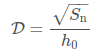

while the latter is a more involved expression wich also depends on the duration of the dataset at hand and the detector's response function. It is important to note, however, that ρ and D scale reciprocally: "weak" signals have a low SNR and a high depth (since they are "buried deeper into the noise" than a strong signal).

## Data generation

As mebtioned before from the split of train and test datasets the challenge creators are encouraging participants to generate their own data but in out case we will keep it at the point of generating samples for explainations and the inbalanced classes problem will be solved with the class weight parameter while training.

A specific sample requires of background noise and optionally a signal. In order to generate noise, one needs to specify a set of detectors (H1 or L1 in this case), the duration of the sample and the Amplitude Spectral Density of the noise sqrtSX. CW analyses are simple in this front, as sqrtSX is proportional to the (stationary) standard deviation of an underlying zero-mean Gaussian process.

Sample duration can be specified in two ways. If the sample contains contiguous data (i.e. the detector was taking science-quality data uninterrupted), one can simply specify the starting time and duration of the sample using tstart and duration. Data with gaps, on the other hand, can be generated by specifying a specific set of timestamps using the timestamps option.

Data is saved as a list of Short Fourier Transforms (SFTs). The duration and windowing of these SFTs can also be modified using Tsft, SFTWindowType and SFTWindowBeta. Most analyses tune Tsft around 1800 seconds order to ensure the power of a putative CW signal stays within a bin.

<a href=https://www.kaggle.com/code/rodrigotenorio/generating-continuous-gravitational-wave-signals> For more details check this notebook: <b>Generating continuous gravitational-wave signals</b></a>

In [ ]:
# Generate signals with parameters drawn from a specific population
num_signals = 2

# These parameters describe background noise and data format
writer_kwargs = {
                "tstart": 1238166018,
                "duration": 4 * 30 * 86400,  
                "detectors": "H1,L1",        
                "sqrtSX": 1e-23,          
                "Tsft": 1800,             
                "SFTWindowType": "tukey", 
                "SFTWindowBeta": 0.01,
               }

In [ ]:
# This class allows us to sample signal parameters from a specific population.
# Implicitly, sky positions are drawn uniformly across the celestial sphere.
# PyFstat also implements a convenient set of priors to sample a population
# of isotropically oriented neutron stars.
signal_parameters_generator = pyfstat.AllSkyInjectionParametersGenerator(
    priors={
        "tref": writer_kwargs["tstart"],
        "F0": {"uniform": {"low": 100.0, "high": 100.1}},
        "F1": lambda: 10**stats.uniform(-12, 4).rvs(),
        "F2": 0,
        "h0": lambda: writer_kwargs["sqrtSX"] / stats.uniform(1, 10).rvs(),
        **pyfstat.injection_parameters.isotropic_amplitude_priors,
    },
)

In [ ]:
snrs = np.zeros(num_signals)

for ind in range(num_signals):

    # Draw signal parameters.
    # Noise can be drawn by setting `params["h0"] = 0
    params = signal_parameters_generator.draw()
    writer_kwargs["outdir"] = f"PyFstat_example_data_ensemble/Signal_{ind}"
    writer_kwargs["label"] = f"Signal_{ind}"
    
    writer = pyfstat.Writer(**writer_kwargs, **params)
    writer.make_data()
    
    # SNR can be compute from a set of SFTs for a specific set
    # of parameters as follows:
    snr = pyfstat.SignalToNoiseRatio.from_sfts(
        F0=writer.F0, sftfilepath=writer.sftfilepath
    )
    squared_snr = snr.compute_snr2(
        Alpha=writer.Alpha, 
        Delta=writer.Delta,
        psi=writer.psi,
        phi=writer.phi, 
        h0=writer.h0,
        cosi=writer.cosi
    )
    snrs[ind] = np.sqrt(squared_snr)
    
    # Data can be read as a numpy array using PyFstat
    frequency, timestamps, amplitudes = pyfstat.utils.get_sft_as_arrays(
        writer.sftfilepath
    )
    
    fig, ax = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f"Signal {ind} - SNR: {snrs[ind]:.2f}")
    for d_ind, detector in enumerate(amplitudes.keys()):
        ax[d_ind][0].set(xlabel="Timestamps [GPS]",
                         ylabel="Frequency [Hz]",
                         title=f"{detector} - Real part")
        ax[d_ind][1].set(xlabel="Timestamps [GPS]",
                         ylabel="Frequency [Hz]",
                         title=f"{detector} - Imaginary part")
        
        c0 = ax[d_ind][0].pcolormesh(timestamps[detector], frequency,
                                     amplitudes[detector].real)
        c1 = ax[d_ind][1].pcolormesh(timestamps[detector], frequency,
                                     amplitudes[detector].imag)
        
        fig.colorbar(c0, ax=ax[d_ind][0])
        fig.colorbar(c1, ax=ax[d_ind][1])
    plt.show()

## Modeling with LSTM in Time Domain

Long short-term memory (LSTM) is an artificial neural network used in the fields of artificial intelligence and deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. Such a recurrent neural network (RNN) can process not only single data points (such as images), but also entire sequences of data (such as speech or video). For example, LSTM is applicable to tasks such as unsegmented, connected handwriting recognition, speech recognition, machine translation, robot control, video games, and healthcare. LSTM has become the most cited neural network of the 20th century.

<img src=https://www.mdpi.com/sensors/sensors-21-05625/article_deploy/html/images/sensors-21-05625-g001.png width=800/>

The name of LSTM refers to the analogy that a standard RNN has both "long-term memory" and "short-term memory". The connection weights and biases in the network change once per episode of training, analogous to how physiological changes in synaptic strengths store long-term memories; the activation patterns in the network change once per time-step, analogous to how the moment-to-moment change in electric firing patterns in the brain store short-term memories. The LSTM architecture aims to provide a short-term memory for RNN that can last thousands of timesteps, thus "long short-term memory".

A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell.

LSTM networks are well-suited to classifying, processing and making predictions based on time series data, since there can be lags of unknown duration between important events in a time series. LSTMs were developed to deal with the vanishing gradient problem that can be encountered when training traditional RNNs. Relative insensitivity to gap length is an advantage of LSTM over RNNs, hidden Markov models and other sequence learning methods in numerous applications.

The compact forms of the equations for the forward pass of an LSTM cell with a forget gate are:

<img src=https://wikimedia.org/api/rest_v1/media/math/render/svg/dc89390b3136ccbbc223a1ed110c6d2b4856069c width=300/>

In [ ]:
X_l = np.asarray(time_df['L1_resampled_time'].to_list())
X_h = np.asarray(time_df['H1_resampled_time'].to_list())
y = np.asarray(time_df['label'].to_list())

X_l = np.expand_dims(X_l, axis=1)
X_h = np.expand_dims(X_h, axis=1)

In [ ]:
X_test_l = np.asarray(time_test_df['L1_resampled_time'].to_list())
X_test_h = np.asarray(time_test_df['H1_resampled_time'].to_list())

X_test_l = np.expand_dims(X_test_l, axis=1)
X_test_h = np.expand_dims(X_test_h, axis=1)

In [ ]:
def create_lstm(x_input):
        
    lstm = tf.keras.Sequential([
        
        tf.keras.layers.LSTM(128, kernel_initializer='normal',input_shape=(1, X_l.shape[2]), return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.LSTM(128, kernel_initializer='normal', return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.LSTM(128, kernel_initializer='normal', return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Dense(units=128, kernel_initializer='normal', activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3), 
                          bias_regularizer=regularizers.L2(1e-2),
                          activity_regularizer=regularizers.L2(1e-3)),
        tf.keras.layers.Dropout(0.5)
    ])
    
    features = lstm(x_input)
    x = layers.Dense(256, activation='relu')(features)
    return x

In [ ]:
def get_lstm_model():
    # 1) Hanford 
    h_input = tf.keras.layers.Input(shape=(1,X_l.shape[2]), name='x_h')
    # 2) Livingston 
    l_input = tf.keras.layers.Input(shape=(1, X_l.shape[2]), name='x_l')
    
    h_out = create_lstm(h_input)
    l_out = create_lstm(l_input)

    
    # Concatenate embeddings
    x = tf.keras.layers.Concatenate()([h_out, l_out])
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, kernel_initializer='normal')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    # Target prediction in range [0,1] with sigmoid activation
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    # Model
    inputs = [h_input, l_input]
    model = tf.keras.models.Model(inputs=inputs, outputs=output)
    
    optimizer = 'adam'

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics = [
            tf.keras.metrics.AUC() ,
        ]
    )
    return model

In [ ]:
tf.keras.backend.clear_session()
gc.collect()
lstmmodel = get_lstm_model()

In [ ]:
print(lstmmodel.summary())

In [ ]:
plot_model(lstmmodel, show_shapes=True, show_layer_names=False, to_file="lstmmodel.png")

In [ ]:
lstmhistory = lstmmodel.fit(
        x=[X_l, X_h],
        y=y,
        epochs = 50,
        validation_split=0.2,
        verbose = 1,
    )

In [ ]:
plt.figure(figsize=(12,10))

plt.suptitle('Optimizer : Adam, Loss : Binary CrossEntropy', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(lstmhistory.history['loss'], label='Training Loss')
plt.plot(lstmhistory.history['val_loss'], label='Validatoin Loss')
plt.legend(loc='upper right')

In [ ]:
lstmpredictions = lstmmodel.predict(x=[X_test_l, X_test_h])

In [ ]:
lstmpredictions

In [ ]:
test = np.reshape(lstmpredictions, lstmpredictions.shape[0])

In [ ]:
df_sub = test_df.assign(target=test)

In [ ]:
df_sub = df_sub.drop(['freq', 'L1_ts','H1_ts'], axis=1)

In [ ]:
df_sub.head()

In [ ]:
df_sub.to_csv('submission.csv', index=False)

## Saving LSTM Model weights

In [ ]:
lstmmodel.save_weights('lstmmodel.h5')

## Releasing Memory

In [ ]:
del time_df, train_df

In [ ]:
gc.collect()

## Modeling with Convolutional Neural Network(CNN) in Frequency Domain

In deep learning, a convolutional neural network (CNN, or ConvNet) is a class of artificial neural network (ANN), most commonly applied to analyze visual imagery. CNNs are also known as Shift Invariant or Space Invariant Artificial Neural Networks (SIANN), based on the shared-weight architecture of the convolution kernels or filters that slide along input features and provide translation-equivariant responses known as feature maps. Counter-intuitively, most convolutional neural networks are not invariant to translation, due to the downsampling operation they apply to the input. They have applications in image and video recognition, recommender systems, image classification, image segmentation, medical image analysis, natural language processing, brain–computer interfaces, and financial time series.

<img src= https://production-media.paperswithcode.com/method_collections/cnn.jpeg width=700/>

CNNs are regularized versions of multilayer perceptrons. Multilayer perceptrons usually mean fully connected networks, that is, each neuron in one layer is connected to all neurons in the next layer. The "full connectivity" of these networks make them prone to overfitting data. Typical ways of regularization, or preventing overfitting, include: penalizing parameters during training (such as weight decay) or trimming connectivity (skipped connections, dropout, etc.) CNNs take a different approach towards regularization: they take advantage of the hierarchical pattern in data and assemble patterns of increasing complexity using smaller and simpler patterns embossed in their filters. Therefore, on a scale of connectivity and complexity, CNNs are on the lower extreme. 

## Generating 360x360 Dataset

The general idea is to split the SFTs into a real and imaginary frame and split the frames into 360x360 patches. A 360x720 SFT will be split into 2 360x360 patches and a 360x1080 SFT will be split into 3 360x360 patches. The original SFTs are truncated to a multiple of 360, thus a 360x750 SFT will be split into 2 360x306 patches, dropping the remaining 360x30 patch. These channels can be fed into a CNN model.

Since each recording consists of two locations, H (Hanford) and L (Livingston), and each SFT is split into a real and imaginary part, each timestamp has 4 "channels".

For more details, see <a href='https://www.kaggle.com/code/markwijkhuizen/g2net-eda-360x360-dataset-creation/notebook'>Mark Wijkhuizen</a>

In [ ]:
# Number of Samples in train dataset
N_SAMPLES = len(labels_df)
# Make 360x360 Patches
TARGET_HEIGHT = 360
TARGET_WIDTH = 360
print(f'TARGET_HEIGHT: {TARGET_HEIGHT}, TARGET_WIDTH: {TARGET_WIDTH}')
IS_INTERACTIVE = os.environ['KAGGLE_KERNEL_RUN_TYPE'] == 'Interactive'
INPUTS = ['x_h_r', 'x_h_i', 'x_l_r', 'x_l_i']

In [ ]:
# Get recording data type
# A handful of complex128 recordings are present which will be ignored
def get_dtype(train_id):
    file = h5py.File(f'{TRAIN_PATH}/{train_id}.hdf5', 'r')[train_id]
    return file['H1']['SFTs'].dtype

labels_df['dtype'] = labels_df['id'].apply(get_dtype)

In [ ]:
N_FLOAT64_SAMPLES = (labels_df['dtype'] == 'complex64').sum()
print(f'N_FLOAT64_SAMPLES: {N_FLOAT64_SAMPLES}')

display(labels_df['dtype'].value_counts().to_frame())

In [ ]:
train_dimension_rows = []

for train_id in tqdm(labels_df['id']):       
    file = h5py.File(f'{TRAIN_PATH}/{train_id}.hdf5', 'r')[train_id]
    SFT_H = file['H1']['SFTs']
    SFT_L = file['L1']['SFTs']
    train_dimension_rows.append({
        'id': train_id,
        'H_height': SFT_H.shape[0],
        'H_width': SFT_H.shape[1],
        'L_height': SFT_L.shape[0],
        'L_width': SFT_L.shape[1],
    })        

In [ ]:
labels_df = labels_df.merge(pd.DataFrame(train_dimension_rows), on='id')
display(labels_df.head())

In [ ]:
labels_df[['H_height', 'L_height']].value_counts().to_frame(name='Count')

In [ ]:
# Create target directories
!rm -rf train_samples
!mkdir -p train_samples/{x,target}
!ls -l train_samples

In [ ]:
# This large function actually generates the 360x360 patches
def get_train_stats():
    c = 0
    # Loop over all training samples
    for row_idx, row in tqdm(labels_df.iterrows(), total=N_SAMPLES):        
        train_id = row['id']
        # Skip non-complex64 samples
        if row['dtype'] != 'complex64':
            continue
            
        # Read SFTs as numpy arrays
        with h5py.File(f'{TRAIN_PATH}/{train_id}.hdf5', 'r') as file:
            SFT_H = np.array(file[train_id]['H1']['SFTs'])
            SFT_L = np.array(file[train_id]['L1']['SFTs'])
        
        # Split into real and imaginary part
        SFT_H_SPLIT = SFT_H.view(np.float32).reshape([*SFT_H.shape, 2])
        SFT_L_SPLIT = SFT_L.view(np.float32).reshape([*SFT_L.shape, 2])
        # Transpose to get channel(real/imaginary) first
        SFT_H_SPLIT = np.transpose(SFT_H_SPLIT, [2,0,1])
        SFT_L_SPLIT = np.transpose(SFT_L_SPLIT, [2,0,1])
        
        # Create target array
        N = min(row['H_width'], row['L_width']) // TARGET_HEIGHT
        x = np.zeros(shape=[N, len(INPUTS), TARGET_HEIGHT, TARGET_HEIGHT], dtype=np.float32)
        # Get patches
        for offset in range(N):
            x[offset, 0] = SFT_H_SPLIT[0, :, offset * TARGET_HEIGHT:(offset + 1) * TARGET_HEIGHT]
            x[offset, 1] = SFT_H_SPLIT[1, :, offset * TARGET_HEIGHT:(offset + 1) * TARGET_HEIGHT]
            x[offset, 2] = SFT_L_SPLIT[0, :, offset * TARGET_HEIGHT:(offset + 1) * TARGET_HEIGHT]
            x[offset, 3] = SFT_L_SPLIT[1,:, offset * TARGET_HEIGHT:(offset + 1) * TARGET_HEIGHT]

        
        
        # Save patches and target
        np.save(f'./train_samples/x/{c}.npy', x)
        np.save(f'./train_samples/target/{c}.npy', np.array(row['target']))
        c += 1
    
    return c

N_TRAIN_SAMPLES = get_train_stats()
print(f'N_TRAIN_SAMPLES: {N_TRAIN_SAMPLES}')

In [ ]:
SAMPLE_IDXS = np.arange(len(glob.glob('./train_samples/target/*')))
print(f'SAMPLE_IDXS shape: {SAMPLE_IDXS.shape}')

In [ ]:
random.shuffle(SAMPLE_IDXS)

In [ ]:
SAMPLE_TEST_IDXS = np.arange(len(glob.glob('./train_samples/target/*')))
print(f'SAMPLE_IDXS shape: {SAMPLE_IDXS.shape}')

In [ ]:
# Training dataset chooses a random 360x360 patch from a recording
def get_train_dataset(idxs, bs):
    while True:
        X = {
                'x_h_r': np.zeros(shape=[bs,TARGET_HEIGHT, TARGET_WIDTH], dtype=np.float32),
                'x_h_i': np.zeros(shape=[bs,TARGET_HEIGHT, TARGET_WIDTH], dtype=np.float32),
                'x_l_r': np.zeros(shape=[bs,TARGET_HEIGHT, TARGET_WIDTH], dtype=np.float32),
                'x_l_i': np.zeros(shape=[bs,TARGET_HEIGHT, TARGET_WIDTH], dtype=np.float32),
            }
        y = np.zeros(shape=[bs], dtype=np.int8)
        for i in range(bs):
            # Choose random file path
            index = np.random.choice(idxs, 1).squeeze()

            # Load x and choose random frame
            XX = np.load(f'./train_samples/x/{index}.npy')
            # Choose random patch
            patch_index = np.random.choice(len(XX), 1).squeeze()
            X['x_h_r'][i] = XX[patch_index, 0]
            X['x_h_i'][i] = XX[patch_index, 1]
            X['x_l_r'][i] = XX[patch_index, 2]
            X['x_l_i'][i] = XX[patch_index, 3]

            # Load target
            y[i] = np.load(f'./train_samples/target/{index}.npy')
        
        yield X, y
        

In [ ]:
# Test dataset chooses a random 360x360 patch from a recording
def get_test_dataset(idxs, bs):
    while True:
        X = {
                'x_h_r': np.zeros(shape=[bs,TARGET_HEIGHT, TARGET_WIDTH], dtype=np.float32),
                'x_h_i': np.zeros(shape=[bs,TARGET_HEIGHT, TARGET_WIDTH], dtype=np.float32),
                'x_l_r': np.zeros(shape=[bs,TARGET_HEIGHT, TARGET_WIDTH], dtype=np.float32),
                'x_l_i': np.zeros(shape=[bs,TARGET_HEIGHT, TARGET_WIDTH], dtype=np.float32),
            }
        y = np.zeros(shape=[bs], dtype=np.int8)
        for i in range(bs):
            # Choose random file path
            index = np.random.choice(idxs, 1).squeeze()

            # Load x and choose random frame
            XX = np.load(f'./train_samples/x/{index}.npy')
            # Choose random patch
            patch_index = np.random.choice(len(XX), 1).squeeze()
            X['x_h_r'][i] = XX[patch_index, 0]
            X['x_h_i'][i] = XX[patch_index, 1]
            X['x_l_r'][i] = XX[patch_index, 2]
            X['x_l_i'][i] = XX[patch_index, 3]

            # Load target
            y[i] = np.load(f'./train_samples/target/{index}.npy')
        
        yield X, y
        

In [ ]:
# Train batch statistics
def train_dataset_test():
    train_dataset = get_train_dataset(SAMPLE_IDXS, 64)
    X, y = next(train_dataset)
    for k in INPUTS:
        print(f'X {k} shape: {X[k].shape}, dtype: {X[k].dtype}', end=', ')
        print(f'X {k} mean: {X[k].mean():.2E}, std: {X[k].std():.2f}, min: {X[k].min():.2f}, max: {X[k].max():.2f}')
    print(f'y: {y}')
    
train_dataset_test()

## Setting up general Parameters

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 30
image_size = 360  # We'll resize input images to this size
patch_size = 40  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

## Implement MLP

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Implement patch creation as a layer


In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [ ]:
plt.figure(figsize=(8, 8))
images = np.load(f'./train_samples/x/{np.random.choice(SAMPLE_IDXS, 1)[0]}.npy')[np.random.choice(len(np.load(f'./train_samples/x/{np.random.choice(SAMPLE_IDXS, 1)[0]}.npy')), 1).squeeze()]
image = images[0]
plt.grid(False)
plt.imshow(image)

img = tf.reshape(image, (1, 360, 360, 1))
resized_image = tf.image.resize(
    tf.convert_to_tensor(img), size=(image_size, image_size)
)
print(resized_image.shape)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(8, 8))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 1))
    plt.imshow(patch_img.numpy())
    plt.axis("off")

## Creating the patch encoder

The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim. In addition, it adds a learnable position embedding to the projected vector.


In [ ]:
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

## Building CNN based Model

In [ ]:
arch = tf.keras.Sequential([
    
        tf.keras.layers.Conv2D(filters=64,kernel_size=(5,5),strides=(2,2), activation="relu", padding="valid",input_shape=(image_size,image_size,3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=32,kernel_size=(5,5),strides=(2,2), activation="relu", padding="valid"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
    
        tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),strides=(2,2), activation="relu", padding="valid",input_shape=(image_size,image_size,3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),strides=(2,2), activation="relu", padding="valid"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
    
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=512, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3), 
                          bias_regularizer=regularizers.L2(1e-2),
                          activity_regularizer=regularizers.L2(1e-3)),
])
def create_cnn(x_input):
    
    inputs = tf.expand_dims(x_input, axis=-1)
    inputs = tf.tile(inputs, [1,1,1,3])
    cnn = tf.keras.Sequential([
    
        tf.keras.layers.Conv2D(filters=64,kernel_size=(5,5),strides=(2,2), activation="relu", padding="valid",input_shape=(image_size,image_size,3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=32,kernel_size=(5,5),strides=(2,2), activation="relu", padding="valid"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
    
        tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),strides=(2,2), activation="relu", padding="valid",input_shape=(image_size,image_size,3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),strides=(2,2), activation="relu", padding="valid"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
    
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=512, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3), 
                          bias_regularizer=regularizers.L2(1e-2),
                          activity_regularizer=regularizers.L2(1e-3)),
    ])
    features = cnn(inputs)
    x = layers.Dense(256, activation='relu')(features)
    return x

## Function to get cnn model

In [ ]:
def get_cnn_model():
    # 1) Hanford Real
    h_r_input = tf.keras.layers.Input(shape=[TARGET_HEIGHT, TARGET_WIDTH], dtype=tf.float32, name='x_h_r')
    # 2) Hanford imaginary
    h_i_input = tf.keras.layers.Input(shape=[TARGET_HEIGHT, TARGET_WIDTH], dtype=tf.float32, name='x_h_i')
    # 3) Livingston Real
    l_r_input = tf.keras.layers.Input(shape=[TARGET_HEIGHT, TARGET_WIDTH], dtype=tf.float32, name='x_l_r')
    # 4) Livingston Imaginary
    l_i_input = tf.keras.layers.Input(shape=[TARGET_HEIGHT, TARGET_WIDTH], dtype=tf.float32, name='x_l_i')
    
    # Get embedding from cnn
    h_r_embed = create_cnn(h_r_input)
    h_i_embed = create_cnn(h_i_input)
    l_r_embed = create_cnn(l_r_input)
    l_i_embed = create_cnn(l_i_input)
    
    # Concatenate embeddings
    x = tf.keras.layers.Concatenate()([h_r_embed, h_i_embed, l_r_embed, l_i_embed])
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    # Target prediction in range [0,1] with sigmoid activation
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    # Model
    inputs = [h_r_input, h_i_input, l_r_input, l_i_input]
    model = tf.keras.models.Model(inputs=inputs, outputs=output)
    
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics = [
            tf.keras.metrics.AUC(),
        ]
    )
    return model

## Exploring CNN in action

In [ ]:
tf.keras.backend.clear_session()
gc.collect()
cnnmodel = get_cnn_model()

In [ ]:
print(cnnmodel.summary())

In [ ]:
plot_model(cnnmodel, show_shapes=True, show_layer_names=False, to_file='cnnmodel.png')

In [ ]:
visualkeras.layered_view(arch, legend=True)

In [ ]:
class_weights = {0:1.5, 1:0.75}
cnnhistory = cnnmodel.fit(
        get_train_dataset(SAMPLE_IDXS, batch_size),
        steps_per_epoch=N_TRAIN_SAMPLES // batch_size,
        epochs = 10,
        class_weight=class_weights,
        verbose = 1,
    )

## Saving CNN weights

In [ ]:
cnnmodel.save_weights('g2net_cnn.h5')

## Binary Cross Entropy Loss Curve

In [ ]:
plt.figure(figsize=(20,10))
plt.ylabel('Loss', fontsize=16)
plt.plot(cnnhistory.history['loss'], label='CNN Training Loss', c = 'darkred')

plt.legend(loc='upper right')

## Notes about Frequency Domain modeling

* The model loss curve is descending but it doesn't mean that the model is learning well, that's why further INVESTIGATION and IMPROVEMENTS shall be done on this work to find out if the imbalanced classes is the main issue here or if we need to try feature extraction techniques(noise cancelation filters, etc.) other than using the SFT's available. One of the possible improvements here is to use pre-trained model and only fine tune it, this shall overcome data limitation  and other issues.